In [1]:
## The purpose of this notebook is compare a few classifiers for discrete problems, like spam filtering.
## I'll use the data from this website: http://www.aueb.gr/users/ion/data/enron-spam/index.html

## import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from collections import Counter
import scipy.sparse
from prettytable import PrettyTable
import gc

## garbage collection
gc.collect();

In [2]:
## load the data

## assemble the file lists
spam_file_list1 = ['data/preprocessed/enron1/spam/' + filename for filename in os.listdir('data/preprocessed/enron1/spam')]
spam_file_list2 = ['data/preprocessed/enron2/spam/' + filename for filename in os.listdir('data/preprocessed/enron2/spam')]
spam_file_list3 = ['data/preprocessed/enron3/spam/' + filename for filename in os.listdir('data/preprocessed/enron3/spam')]
spam_file_list4 = ['data/preprocessed/enron4/spam/' + filename for filename in os.listdir('data/preprocessed/enron4/spam')]
spam_file_list5 = ['data/preprocessed/enron5/spam/' + filename for filename in os.listdir('data/preprocessed/enron5/spam')]
spam_file_list6 = ['data/preprocessed/enron6/spam/' + filename for filename in os.listdir('data/preprocessed/enron6/spam')]
spam_file_list = spam_file_list1 + spam_file_list2 + spam_file_list3 + spam_file_list4 + spam_file_list5 + spam_file_list6

## assemble the file lists
ham_file_list1 = ['data/preprocessed/enron1/ham/' + filename for filename in os.listdir('data/preprocessed/enron1/ham')]
ham_file_list2 = ['data/preprocessed/enron2/ham/' + filename for filename in os.listdir('data/preprocessed/enron2/ham')]
ham_file_list3 = ['data/preprocessed/enron3/ham/' + filename for filename in os.listdir('data/preprocessed/enron3/ham')]
ham_file_list4 = ['data/preprocessed/enron4/ham/' + filename for filename in os.listdir('data/preprocessed/enron4/ham')]
ham_file_list5 = ['data/preprocessed/enron5/ham/' + filename for filename in os.listdir('data/preprocessed/enron5/ham')]
ham_file_list6 = ['data/preprocessed/enron6/ham/' + filename for filename in os.listdir('data/preprocessed/enron6/ham')]
ham_file_list = ham_file_list1 + ham_file_list2 + ham_file_list3 + ham_file_list4 + ham_file_list5 + ham_file_list6

## assemble the data
ham_data = []
for i in range(len(ham_file_list)):
  with open(ham_file_list[i], 'r') as myfile:
    ham_data.append(myfile.read().replace('\r\n',''))

spam_data = []
for i in range(len(spam_file_list)):
  with open(spam_file_list[i], 'r') as myfile:
    spam_data.append(myfile.read().replace('\r\n',''))

In [3]:
## drop a fraction of the data (optional, used for building the code)
frac = 0.9 #fraction to drop
inds = set(random.sample(list(range(len(ham_data))), int(frac*len(ham_data))))
ham_data = [n for i,n in enumerate(ham_data) if i not in inds]
inds = set(random.sample(list(range(len(spam_data))), int(frac*len(spam_data))))
spam_data = [n for i,n in enumerate(spam_data) if i not in inds]

print len(ham_data)
print len(spam_data)

1655
1718


In [4]:
## further processing: remove punctuation and numbers, tokenize

## define a processing function that 1) lowers the case, 2) tokenizes into words, 3) lemmatizes
wordnet_lemmatizer = WordNetLemmatizer()
def process(sentence):
  return [wordnet_lemmatizer.lemmatize(word.lower()) for word in nltk.word_tokenize(sentence)]

## load the list of english stop words
stoplist = stopwords.words('english')
stoplist.append('subject') #the emails all include a 'subject: XXX' header

## set-up regular expressions to delete all non a-z characters
regex = re.compile('[^a-zA-Z]')

## list of punctuation symbols to remove
exclude = set(string.punctuation)

## list of printable characters
printable = set(string.printable)

In [5]:
spam_words = []
for i in range(len(spam_data)):
  ## remove non-printable characters
  text_dummy = filter(lambda x: x in printable, spam_data[i])
  ## drop punctuation, tokenize into words, lower the case, and lemmatize
  text_dummy = ''.join(ch for ch in text_dummy if ch not in exclude)
  words_dummy = process(text_dummy)
  ## remove stop words
  words_dummy = [w for w in words_dummy if not w in stoplist]
  ## remove numbers
  words_dummy = [regex.sub('', w) for w in words_dummy if len(regex.sub('', w)) > 0]
  
  spam_words.append(words_dummy)

ham_words = []
for i in range(len(ham_data)):
  ## remove non-printable characters
  text_dummy = filter(lambda x: x in printable, ham_data[i])
  ## drop punctuation, tokenize into words, lower the case, and lemmatize
  text_dummy = ''.join(ch for ch in text_dummy if ch not in exclude)
  words_dummy = process(text_dummy)
  ## remove stop words
  words_dummy = [w for w in words_dummy if not w in stoplist]
  ## remove numbers
  words_dummy = [regex.sub('', w) for w in words_dummy if len(regex.sub('', w)) > 0]

  ham_words.append(words_dummy)

## drop any instances where all the words have been removed
spam_words = [ i for i in spam_words if len(i) != 0]
ham_words = [ i for i in ham_words if len(i) != 0]

In [6]:
## put the data into dataframe form
words = spam_words + ham_words
classes = [1]*len(spam_words) + [0]*len(ham_words)
headers = ['class', 'words']
df = pd.DataFrame([classes, words])
df = df.transpose()
df.columns = headers

## shuffle
df = df.sample(frac=1).reset_index(drop=True)

## split off a CV set
cvratio = .2 # fraction to split off
df_cv = df.copy(deep=True)
df_cv = df_cv.iloc[:int(math.floor(cvratio*len(df)))]
df_cv = df_cv.reset_index(drop=True)
df = df.iloc[int(math.floor(cvratio*len(df))):]
df = df.reset_index(drop=True)

In [7]:
## convert the list of words to a list of word ranks
words_tot = [item for sublist in df['words'] for item in sublist]
count = Counter(words_tot).most_common()
words_unique = [count[i][0] for i in range(len(count))]
words_frequencies = [count[i][1] for i in range(len(count))]

def word_to_rank(x):
  return sorted([ words_unique.index(w) for w in x if w in words_unique])

df['word_ranks'] = df['words'].map(word_to_rank)
df_cv['word_ranks'] = df_cv['words'].map(word_to_rank)

training set statistics:
total number of words: 370767
total number of unique words: 55042
lexical diversity: 0.148454420161


+-------------+-------+
| Word        | Count |
+-------------+-------+
| enron       |  4559 |
| company     |  2211 |
| ect         |  1959 |
| ha          |  1508 |
| please      |  1443 |
| com         |  1410 |
| u           |  1311 |
| e           |  1271 |
| new         |  1255 |
| wa          |  1243 |
| hou         |  1193 |
| may         |  1141 |
| would       |  1122 |
| said        |  1091 |
| time        |  1082 |
| price       |   970 |
| business    |   918 |
| one         |   895 |
| information |   890 |
| market      |   878 |
+-------------+-------+


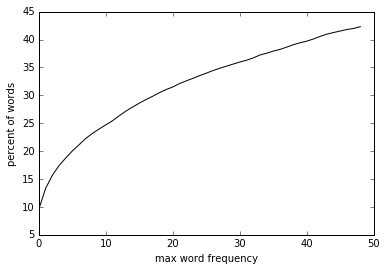

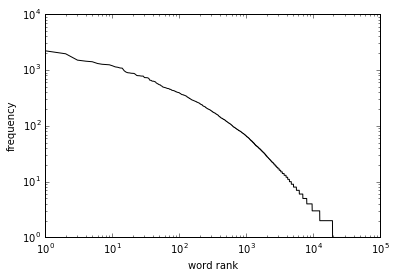

In [8]:
## print out some preliminary statistics

## lexical diversity
def lexical_diversity(tokens):
    return 1.0*len(set(tokens))/len(tokens) 

print 'training set statistics:'
print 'total number of words:', len(words_tot)
print 'total number of unique words:', len(words_unique)
print 'lexical diversity:', lexical_diversity(words_tot)

## examine word frequencies
print '\n'
pt = PrettyTable(field_names=['Word', 'Count']) 
[ pt.add_row(kv) for kv in count[:20] ]
pt.align['Word'], pt.align['Count'] = 'l', 'r' #set column alignment
print pt

## get a sense for the frequency distribution of words
## what % of words occur with frequency <= x
maxwordfreq = [100.0*c*words_frequencies.count(c)/len(words_tot) for c in range(1,50)]
for i in range(1,len(maxwordfreq)):
  maxwordfreq[i] += maxwordfreq[i-1]
%matplotlib inline
plt.plot(maxwordfreq, c='black')
plt.ylabel('percent of words')
plt.xlabel('max word frequency')
plt.show()

## plot frequency(rank)
words_tot_counts = sorted(Counter(words_tot).values(), reverse=True)
plt.loglog(words_tot_counts, c='black')
plt.ylabel('frequency')
plt.xlabel('word rank')
plt.show()

In [20]:
## drop all the words that show up <= p times
p = 0
if p>0:
  K=len(words_tot)
  for k in range(len(words_frequencies)):
    if words_frequencies[k] == p:
      K=k
      break

  word_ranks_small = []
  for i in range(len(df)):
    word_ranks_small.append( [w for w in df['word_ranks'].iloc[i] if w < K] )
  df['word_ranks_small'] = word_ranks_small

  print '% retained:', 100.0*len([item for sublist in df['word_ranks_small'] for item in sublist]) \
   /len([item for sublist in df['word_ranks'] for item in sublist])

In [10]:
## build the bag of words
max_rank = len(words_frequencies)
Ndocs = len(df)
Ndocs_cv = len(df_cv)

ranks_tot = [item for sublist in df['word_ranks_small'] for item in sublist]
ranks_tot_spam = [item for sublist in df['word_ranks_small'][df['class'] == 1] for item in sublist]
ranks_tot_ham = [item for sublist in df['word_ranks_small'][df['class'] == 0] for item in sublist]
counter = Counter(ranks_tot)
counter_spam = Counter(ranks_tot_spam)
counter_ham = Counter(ranks_tot_ham)

In [11]:
################################################################
## Naive Bayes classifier

##re-think Laplace smoothing now that I'm ignoring new words in cv set

## priors
prior_ham = float(sum(df['class']==0))/Ndocs
prior_spam = float(sum(df['class']==1))/Ndocs

## conditional probabilities of word given class (with Laplace smoothing parameter alpha)
alpha = 1 # Laplace smoothing parameter
def p_rank_given_spam(rank):
  return float(counter_spam[rank] + alpha)/(len(ranks_tot_spam) + alpha*len(ranks_tot))
def p_rank_given_ham(rank):
  return float(counter_ham[rank] + alpha)/(len(ranks_tot_ham) + alpha*len(ranks_tot))

## class prediction
def predict(rank_list):
  p_spam = math.log(prior_spam) + sum([math.log(p_rank_given_spam(i)) for i in rank_list])
  p_ham = math.log(prior_ham) + sum([math.log(p_rank_given_ham(i)) for i in rank_list])
  return [p_ham, p_spam].index(max([p_ham, p_spam]))

## classification error
df_cv['predictions'] = df_cv['word_ranks_small'].map(predict)
print 'CV set: correctly classified:', 100*float(sum(df_cv['predictions'] == df_cv['class']))/Ndocs_cv, '%'

CV set: correctly classified: 95.690936107 %


In [12]:
print 'd.o.f. in Nigam:', "{:.3e}".format(20101*57000)
print 'd.o.f. here:', "{:.3e}".format(max_rank*len(df))

d.o.f. in Nigam: 1.146e+09
d.o.f. here: 1.482e+08


In [15]:
################################################################
## MaxEnt Classifier

## the class assignments as a vector
C = np.asarray(df['class'], dtype=float)
C_cv = np.asarray(df_cv['class'], dtype=int)

## create the features f_w(d), considered as a sparse, integer-valued matrix
feature = scipy.sparse.lil_matrix((Ndocs, max_rank))
for j in range(Ndocs):
  for i in range(len(df['word_ranks'].iloc[j])):
    feature[j, df['word_ranks'].iloc[j][i]] += 1.0/(len(df['word_ranks'].iloc[j]))
## convert the features into sparse matrices again
feature = scipy.sparse.csr_matrix(feature)

## create the features f_w(d), considered as a sparse, integer-valued matrix
feature_cv = scipy.sparse.lil_matrix((Ndocs_cv, max_rank))
for j in range(Ndocs_cv):
  for i in range(len(df_cv['word_ranks'].iloc[j])):
    feature_cv[j, df_cv['word_ranks'].iloc[j][i]] += 1.0/(len(df_cv['word_ranks'].iloc[j]))
## convert the features into sparse matrices again
feature_cv = scipy.sparse.csr_matrix(feature_cv)

In [16]:
## useful functions

## compute the log likelihood
def loglike(lambda_spam, lambda_ham, flambda_spam, flambda_ham):
  return flambda_spam.dot(C) + flambda_ham.dot(1-C) - sum(np.log(np.exp(flambda_spam) + np.exp(flambda_ham)))

## compute the gradient
def gradient(lambda_spam, lambda_ham, flambda_spam, flambda_ham):
  boltzmann_spam = np.exp(flambda_spam)
  boltzmann_ham = np.exp(flambda_ham)
  dLLdlambda_spam = feature.transpose().dot(C) - feature.transpose().dot( (boltzmann_spam/(boltzmann_spam + boltzmann_ham) ) )
  dLLdlambda_ham = feature.transpose().dot(1-C) - feature.transpose().dot( (boltzmann_ham/(boltzmann_spam + boltzmann_ham) ) )
  return [dLLdlambda_spam, dLLdlambda_ham]

## compute gradient via finite differences
def gradient_FD(lambda_spam, lambda_ham, flambda_spam, flambda_ham, epsilon):
  LL1 = loglike(lambda_spam, lambda_ham, flambda_spam, flambda_ham)
  dLLdlambda_spam_FD = [0 for i in range(max_rank)]
  dLLdlambda_ham_FD = [0 for i in range(max_rank)]
  for i in range(len(lambda_spam)):
    lambda_spam_2 = np.copy(lambda_spam)
    lambda_ham_2 = np.copy(lambda_ham)
    lambda_spam_2[i] += epsilon #update only the spam lambda
    flambda_spam_2 = feature.dot(lambda_spam_2)
    flambda_ham_2 = feature.dot(lambda_ham_2)
    LL2 = loglike(lambda_spam_2, lambda_ham_2, flambda_spam_2, flambda_ham_2)
    dLLdlambda_spam_FD[i] = (LL2 - LL1)/epsilon
  for i in range(len(lambda_spam)):
    lambda_spam_2 = np.copy(lambda_spam)
    lambda_ham_2 = np.copy(lambda_ham)
    lambda_ham_2[i] += epsilon #update only the ham lambda
    flambda_spam_2 = feature.dot(lambda_spam_2)
    flambda_ham_2 = feature.dot(lambda_ham_2)
    LL2 = loglike(lambda_spam_2, lambda_ham_2, flambda_spam_2, flambda_ham_2)
    dLLdlambda_ham_FD[i] = (LL2 - LL1)/epsilon
  return [dLLdlambda_spam_FD, dLLdlambda_ham_FD]

def predictions(lambda_spam, lambda_ham):
  flambda_spam_cv = feature_cv.dot(lambda_spam)
  flambda_ham_cv = feature_cv.dot(lambda_ham)
  boltzmann_ham_cv = np.squeeze(np.asarray(np.exp(flambda_ham_cv)))
  boltzmann_spam_cv = np.squeeze(np.asarray(np.exp(flambda_spam_cv)))
  return np.array( boltzmann_spam_cv > boltzmann_ham_cv, dtype=int)

In [17]:
## check gradient (very slow)
if False:
  ## create the vector of parameters to be learned (initialized randomly)
  np.random.seed(seed=1)
  lambda_spam = np.random.uniform(0,1,max_rank)
  lambda_ham = np.random.uniform(0,1,max_rank)
  ## useful factors
  flambda_spam = feature.dot(lambda_spam)
  flambda_ham = feature.dot(lambda_ham)
  ## exact gradient
  [dLLdlambda_spam, dLLdlambda_ham] = gradient(lambda_spam, lambda_ham, flambda_spam, flambda_ham)

  print 'error in gradients for epsilon = 0.1'
  [dLLdlambda_spam_FD, dLLdlambda_ham_FD] = gradient_FD(lambda_spam, lambda_ham, flambda_spam, flambda_ham, 0.1)
  print [sum(np.squeeze(np.asarray(dLLdlambda_spam)) - np.asarray(dLLdlambda_spam_FD))/max_rank, \
       sum(np.squeeze(np.asarray(dLLdlambda_ham)) - np.asarray(dLLdlambda_ham_FD))/max_rank]

  print 'error in gradients for epsilon = 0.001'
  [dLLdlambda_spam_FD, dLLdlambda_ham_FD] = gradient_FD(lambda_spam, lambda_ham, flambda_spam, flambda_ham, 0.001)
  print [sum(np.squeeze(np.asarray(dLLdlambda_spam)) - np.asarray(dLLdlambda_spam_FD))/max_rank, \
       sum(np.squeeze(np.asarray(dLLdlambda_ham)) - np.asarray(dLLdlambda_ham_FD))/max_rank]

In [18]:
## Training

## learning rate
alpha = 10.0

## create the vector of parameters to be learned (initialized to zero)
lambda_spam = np.zeros(max_rank)
lambda_ham = np.zeros(max_rank)
## the initial cost and accuracy
flambda_spam = feature.dot(lambda_spam)
flambda_ham = feature.dot(lambda_ham)
## record the log likelihood and the prediction
LL_history = [loglike(lambda_spam, lambda_ham, flambda_spam, flambda_ham)]
predict = predictions(lambda_spam, lambda_ham)
predictions_history = [1.0*sum(predict == C_cv)/len(predict)]

## gradient ascent
Nitermax = 10000
for i in range(Nitermax):
  #print 'training:', str(i+1), 'out of', Nitermax
  ## compute the gradient
  [dLLdlambda_spam, dLLdlambda_ham] = gradient(lambda_spam, lambda_ham, flambda_spam, flambda_ham)
  ## advance the parameters
  lambda_spam = lambda_spam + alpha*dLLdlambda_spam
  lambda_ham = lambda_ham + alpha*dLLdlambda_ham
  ## some useful factors
  flambda_spam = feature.dot(lambda_spam)
  flambda_ham = feature.dot(lambda_ham)
  ## record the log likelihood and the predictions
  LL_history.append(loglike(lambda_spam, lambda_ham, flambda_spam, flambda_ham)) 
  predict = predictions(lambda_spam, lambda_ham)
  predictions_history.append(1.0*sum(predict == C_cv)/len(predict))

final prediction accuracy: 0.964338781575


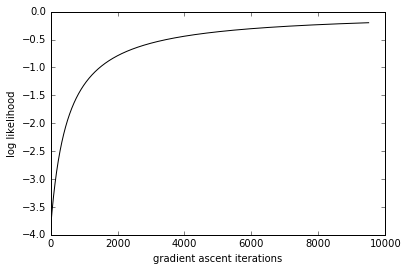

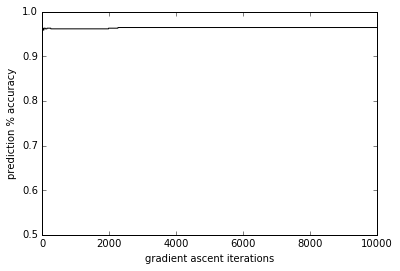

In [19]:
## predictions 
print 'final prediction accuracy:', predictions_history[-1]
#print LL_history;
## plot the training history
%matplotlib inline
plt.plot(LL_history[500:], c='black')
plt.ylabel('log likelihood')
plt.xlabel('gradient ascent iterations')
plt.show()

## plot the training history
%matplotlib inline
plt.plot(predictions_history, c='black')
plt.ylabel('prediction % accuracy')
plt.xlabel('gradient ascent iterations')
plt.show()

In [ ]:
#xxxxxxxxxxxxxxxxxxxxxx OLD CODE xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [ ]:
################################################################
## MaxEnt Classifier (CAN I SPEED THIS UP?)
## simple idea: don't evaluate error each iteration

## the class assignments as a vector
C = np.asarray(df['class'], dtype=float)
C_cv = np.asarray(df_cv['class'], dtype=int)

## create the features f_w(d), considered as a sparse, integer-valued matrix
feature = scipy.sparse.lil_matrix((Ndocs, max_rank))
for j in range(Ndocs):
  for i in range(len(df['word_ranks'].iloc[j])):
    feature[j, df['word_ranks'].iloc[j][i]] += 1.0/(len(df['word_ranks'].iloc[j]))

## create the features f_w(d), considered as a sparse, integer-valued matrix for the CV set
feature_cv = scipy.sparse.lil_matrix((Ndocs_cv, max_rank)).toarray()
for j in range(Ndocs_cv):
  for i in range(len(df_cv['word_ranks'].iloc[j])):
    feature_cv[j, df_cv['word_ranks'].iloc[j][i]] += 1.0/(len(df['word_ranks'].iloc[j]))
    
## convert the features into sparse matrices again
feature = scipy.sparse.csr_matrix(feature)
feature_cv = scipy.sparse.csr_matrix(feature_cv)

## some useful arrays
CC = np.array([C,]*max_rank).transpose()
II = np.ones(CC.shape)
cc = np.array([C,]*1).transpose()
ii = np.array([np.ones(len(C)),]*1).transpose()

In [ ]:
## useful functions

## compute the log likelihood
def loglike(lambda_spam, lambda_ham, flambda_spam, flambda_ham):
  return sum( np.multiply(cc,flambda_spam) + np.multiply(ii-cc,flambda_ham) - np.log( np.exp( flambda_spam ) + np.exp( flambda_ham ) ) )[0,0]

## compute the gradient
def gradient(lambda_spam, lambda_ham, flambda_spam, flambda_ham):
  boltzmann_spam = np.exp(flambda_spam)
  boltzmann_ham = np.exp(flambda_ham)
  dLLdlambda_spam = (feature.multiply(CC) - (feature.multiply(boltzmann_spam)/(boltzmann_spam + boltzmann_ham))).sum(axis=0)
  dLLdlambda_ham = (feature.multiply(II-CC) - (feature.multiply(boltzmann_ham)/(boltzmann_spam + boltzmann_ham))).sum(axis=0)
  return [dLLdlambda_spam, dLLdlambda_ham]

## compute gradient via finite differences
def gradient_FD(lambda_spam, lambda_ham, flambda_spam, flambda_ham, epsilon):
  LL1 = loglike(lambda_spam, lambda_ham, flambda_spam, flambda_ham)
  dLLdlambda_spam_FD = [0 for i in range(max_rank)]
  dLLdlambda_ham_FD = [0 for i in range(max_rank)]
  for i in range(len(lambda_spam)):
    lambda_spam_2 = np.copy(lambda_spam)
    lambda_ham_2 = np.copy(lambda_ham)
    lambda_spam_2[i] += epsilon #update only the spam lambda
    flambda_spam_2 = feature.multiply(lambda_spam_2).sum(axis=1)
    flambda_ham_2 = feature.multiply(lambda_ham_2).sum(axis=1)
    LL2 = loglike(lambda_spam_2, lambda_ham_2, flambda_spam_2, flambda_ham_2)
    dLLdlambda_spam_FD[i] = (LL2 - LL1)/epsilon
  for i in range(len(lambda_spam)):
    lambda_spam_2 = np.copy(lambda_spam)
    lambda_ham_2 = np.copy(lambda_ham)
    lambda_ham_2[i] += epsilon #update only the ham lambda
    flambda_spam_2 = feature.multiply(lambda_spam_2).sum(axis=1)
    flambda_ham_2 = feature.multiply(lambda_ham_2).sum(axis=1)
    LL2 = loglike(lambda_spam_2, lambda_ham_2, flambda_spam_2, flambda_ham_2)
    dLLdlambda_ham_FD[i] = (LL2 - LL1)/epsilon
  return [dLLdlambda_spam_FD, dLLdlambda_ham_FD]

def predictions(lambda_spam, lambda_ham):
  flambda_spam_cv = feature_cv.multiply(lambda_spam).sum(axis=1)
  flambda_ham_cv = feature_cv.multiply(lambda_ham).sum(axis=1)
  boltzmann_ham_cv = np.squeeze(np.asarray(np.exp(flambda_ham_cv)))
  boltzmann_spam_cv = np.squeeze(np.asarray(np.exp(flambda_spam_cv)))
  return np.array( boltzmann_spam_cv > boltzmann_ham_cv, dtype=int)

In [ ]:
## check gradient (very slow)
if True:
  ## create the vector of parameters to be learned (initialized randomly)
  np.random.seed(seed=1)
  lambda_spam = np.random.uniform(0,1,max_rank)
  lambda_ham = np.random.uniform(0,1,max_rank)
  
  ## useful factors
  flambda_spam = feature.multiply(lambda_spam).sum(axis=1)
  flambda_ham = feature.multiply(lambda_ham).sum(axis=1)
  ## exact gradient
  [dLLdlambda_spam, dLLdlambda_ham] = gradient(lambda_spam, lambda_ham, flambda_spam, flambda_ham)

  print 'error in gradients for epsilon = 0.1'
  [dLLdlambda_spam_FD, dLLdlambda_ham_FD] = gradient_FD(lambda_spam, lambda_ham, flambda_spam, flambda_ham, 0.1)
  print [sum(np.squeeze(np.asarray(dLLdlambda_spam)) - np.asarray(dLLdlambda_spam_FD))/max_rank, \
       sum(np.squeeze(np.asarray(dLLdlambda_ham)) - np.asarray(dLLdlambda_ham_FD))/max_rank]

  print 'error in gradients for epsilon = 0.001'
  [dLLdlambda_spam_FD, dLLdlambda_ham_FD] = gradient_FD(lambda_spam, lambda_ham, flambda_spam, flambda_ham, 0.001)
  print [sum(np.squeeze(np.asarray(dLLdlambda_spam)) - np.asarray(dLLdlambda_spam_FD))/max_rank, \
       sum(np.squeeze(np.asarray(dLLdlambda_ham)) - np.asarray(dLLdlambda_ham_FD))/max_rank]

  print sum(np.squeeze(np.asarray(dLLdlambda_spam)))
  print sum(np.asarray(dLLdlambda_spam_FD))

In [ ]:
## Training

## learning rate
alpha = 10.0

## create the vector of parameters to be learned (initialized to zero)
lambda_spam = np.zeros(max_rank)
lambda_ham = np.zeros(max_rank)

## the initial cost and accuracy
flambda_spam = feature.multiply(lambda_spam).sum(axis=1)
flambda_ham = feature.multiply(lambda_ham).sum(axis=1)
## record the log likelihood and the prediction
LL_history = [loglike(lambda_spam, lambda_ham, flambda_spam, flambda_ham)]
predict = predictions(lambda_spam, lambda_ham)
predictions_history = [1.0*sum(predict == C_cv)/len(predict)]

## gradient ascent
Nitermax = 2
for i in range(Nitermax):
  print 'training:', str(i+1), 'out of', Nitermax
  ## compute the gradient
  [dLLdlambda_spam, dLLdlambda_ham] = gradient(lambda_spam, lambda_ham, flambda_spam, flambda_ham)
  ## advance the parameters
  lambda_spam = lambda_spam + alpha*dLLdlambda_spam
  lambda_ham = lambda_ham + alpha*dLLdlambda_ham
  ## reshape
  lambda_spam = np.squeeze(np.asarray(lambda_spam))
  lambda_ham = np.squeeze(np.asarray(lambda_ham))
  ## some useful factors
  flambda_spam = feature.multiply(lambda_spam).sum(axis=1)
  flambda_ham = feature.multiply(lambda_ham).sum(axis=1)

  ## record the log likelihood and the predictions
  LL_history.append(loglike(lambda_spam, lambda_ham, flambda_spam, flambda_ham)) 
  predict = predictions(lambda_spam, lambda_ham)
  predictions_history.append(1.0*sum(predict == C_cv)/len(predict))

In [ ]:
## predictions 
print 'final prediction accuracy:', predictions_history[-1]
#print LL_history;
## plot the training history
%matplotlib inline
plt.plot(LL_history, c='black')
plt.ylabel('log likelihood')
plt.xlabel('gradient ascent iterations')
plt.show()

## plot the training history
%matplotlib inline
plt.plot(predictions_history, c='black')
plt.ylabel('prediction % accuracy')
plt.xlabel('gradient ascent iterations')
plt.show()

In [ ]:
### OLDER VERSIONS
## MaxEnt Classifier
## if I end up dropping some low freq. words I might need to be careful
## worry about possible empty documents

In [ ]:
## learning rate
alpha = 0.1

## create the vector of parameters to be learned (initialized to zero)
lambda_spam = np.ones(len(words_frequencies))
lambda_ham = np.ones(len(words_frequencies))

## the class assignments as a vector
C = np.asarray(df['class'], dtype=float)
C_cv = np.asarray(df_cv['class'], dtype=int)

In [ ]:
## useful intermediate quantities
flambda_spam = [sum([ lambda_spam[r]*df['word_ranks'].iloc[b].count(r)/len(df['word_ranks'].iloc[b]) for r in df['word_ranks'].iloc[b]]) for b in range(len(df))]
flambda_ham = [sum([ lambda_ham[r]*df['word_ranks'].iloc[b].count(r)/len(df['word_ranks'].iloc[b]) for r in df['word_ranks'].iloc[b]]) for b in range(len(df))]
boltzmann_spam = np.exp(flambda_spam)
boltzmann_ham = np.exp(flambda_ham)
## record the log likelihood
LL = sum( C*(flambda_spam) + (1-C)*(flambda_ham) - np.log(np.exp(flambda_spam) + np.exp(flambda_ham)))
LL_history = [LL]

In [ ]:
dldlambda_spam = np.ones(len(words_frequencies))
dldlambda_ham = np.ones(len(words_frequencies))

In [ ]:
for r in range(3):
  dldlambda_spam[r] = sum([lambda_spam[r]*C[b]/len(df['word_ranks'].iloc[b]) for b in range(len(df))])

In [ ]:
butt = sum([lambda_spam[0]*C[b]/len(df['word_ranks'].iloc[b]) for b in range(len(df))])

In [ ]:
## compute the gradient
dldlambda_spam = (feature.multiply(CC) - feature.multiply(boltzmann_spam)/(boltzmann_spam + boltzmann_ham)).sum(axis=0)
dldlambda_ham = (feature.multiply(II-CC) - feature.multiply(boltzmann_ham)/(boltzmann_spam + boltzmann_ham)).sum(axis=0) 

In [ ]:
## advance the parameters
lambda_spam = lambda_spam + alpha*dldlambda_spam
lambda_ham = lambda_ham + alpha*dldlambda_ham 

In [ ]:
################################################################
## MaxEnt Classifier (CAN I SPEED THIS UP?)

## the class assignments as a vector
C = np.asarray(df['class'], dtype=float)
C_cv = np.asarray(df_cv['class'], dtype=int)

## some useful matrices
CC = np.array([C,]*len(words_tot_unique)).transpose()
II = np.ones(CC.shape)

## create the features f_w(d), considered as a sparse, integer-valued matrix
feature = scipy.sparse.csr_matrix((len(df), len(words_tot_unique))).toarray()
for j in range(len(df)):
  for i in range(len(df['words2'].iloc[j])):
    feature[j, words_tot_unique.index(df['words2'].iloc[j][i])] += 1.0/(len(df['words2'].iloc[j]))

## create the features f_w(d), considered as a sparse, integer-valued matrix for the CV set
feature_cv = scipy.sparse.csr_matrix((len(df_cv), len(words_tot_unique))).toarray()
for j in range(len(df_cv)):
  for i in range(len(df_cv['words2'].iloc[j])):
    if df_cv['words2'].iloc[j][i] in words_tot_unique:
      feature_cv[j, words_tot_unique.index(df_cv['words2'].iloc[j][i])] += 1.0/(len(df_cv['words2'].iloc[j]))

## convert the features into sparse matrices again
feature = scipy.sparse.csr_matrix(feature)
feature_cv = scipy.sparse.csr_matrix(feature_cv)

In [ ]:
## Training

## learning rate
alpha = 0.1

## create the vector of parameters to be learned (initialized to zero)
lambda_spam = np.zeros(len(words_tot_unique))
lambda_ham = np.zeros(len(words_tot_unique))

## the initial cost and accuracy
## first some useful Boltzmann factors
flambda_s = feature.multiply(lambda_spam).sum(axis=1)
flambda_h = feature.multiply(lambda_ham).sum(axis=1)
boltzmann_spam = np.exp(flambda_s)
boltzmann_ham = np.exp(flambda_h)
## record the log likelihood
LL = sum( (C*np.squeeze(np.asarray((flambda_s)))) + ((1-C)*np.squeeze(np.asarray((flambda_h)))) \
           - np.log( np.exp( flambda_s ) + np.exp( flambda_h ) ) )[0,0]
LL_history = [LL]
## then the prediction
flambda_s_cv = feature_cv.multiply(lambda_spam).sum(axis=1)
flambda_h_cv = feature_cv.multiply(lambda_ham).sum(axis=1)
boltzmann_ham_cv = np.squeeze(np.asarray(np.exp(flambda_h_cv)))
boltzmann_spam_cv = np.squeeze(np.asarray(np.exp(flambda_s_cv)))
predictions = np.array( boltzmann_spam_cv > boltzmann_ham_cv, dtype=int)
predictions_history = [1.0*sum(predictions == C_cv)/len(predictions)]

## gradient ascent
Nitermax = 200
for i in range(Nitermax):
  print 'training:', str(i+1), 'out of', Nitermax
  ## compute the gradient
  dldlambda_spam = (feature.multiply(CC) - feature.multiply(boltzmann_spam)/(boltzmann_spam + boltzmann_ham)).sum(axis=0)
  dldlambda_ham = (feature.multiply(II-CC) - feature.multiply(boltzmann_ham)/(boltzmann_spam + boltzmann_ham)).sum(axis=0) 
  ## advance the parameters
  lambda_spam = lambda_spam + alpha*dldlambda_spam
  lambda_ham = lambda_ham + alpha*dldlambda_ham
  ## reshape
  lambda_spam = np.squeeze(np.asarray(lambda_spam))
  lambda_ham = np.squeeze(np.asarray(lambda_ham))
  
  ## some useful Boltzmann factors
  flambda_s = feature.multiply(lambda_spam).sum(axis=1)
  flambda_h = feature.multiply(lambda_ham).sum(axis=1)
  boltzmann_spam = np.exp(flambda_s)
  boltzmann_ham = np.exp(flambda_h)
  ## record the log likelihood
  LL = sum( (C*np.squeeze(np.asarray((flambda_s)))) + ((1-C)*np.squeeze(np.asarray((flambda_h)))) \
           - np.log( np.exp( flambda_s ) + np.exp( flambda_h ) ) )[0,0]
  LL_history.append(LL)
  
  ## predictions 
  flambda_s_cv = feature_cv.multiply(lambda_spam).sum(axis=1)
  flambda_h_cv = feature_cv.multiply(lambda_ham).sum(axis=1)
  boltzmann_ham_cv = np.squeeze(np.asarray(np.exp(flambda_h_cv)))
  boltzmann_spam_cv = np.squeeze(np.asarray(np.exp(flambda_s_cv)))
  predictions = np.array( boltzmann_spam_cv > boltzmann_ham_cv, dtype=int)
  predictions_history.append(1.0*sum(predictions == C_cv)/len(predictions))

In [ ]:
## predictions 
print 'final prediction accuracy:', predictions_history[-1]

## plot the training history
%matplotlib inline
plt.plot(LL_history, c='black')
plt.ylabel('log likelihood')
plt.xlabel('gradient ascent iterations')
plt.show()

## plot the training history
%matplotlib inline
plt.plot(predictions_history, c='black')
plt.ylabel('prediction % accuracy')
plt.xlabel('gradient ascent iterations')
plt.show()

In [ ]:
## OLD MaxEnt Classifier -- attempt w/ sparse arrays (very slow)

## the class assignments as a vector
C = np.asarray(df['class'], dtype=float)
C_cv = np.asarray(df_cv['class'], dtype=int)

## create the features f_w(d), considered as a sparse, integer-valued matrix
feature = scipy.sparse.csr_matrix((len(df), len(words_tot_unique))).toarray()
for j in range(len(df)):
  for i in range(len(df['words2'].iloc[j])):
    feature[j, words_tot_unique.index(df['words2'].iloc[j][i])] += 1.0/(len(df['words2'].iloc[j]))

## create the features f_w(d), considered as a sparse, integer-valued matrix for the CV set
feature_cv = scipy.sparse.csr_matrix((len(df_cv), len(words_tot_unique))).toarray()
for j in range(len(df_cv)):
  for i in range(len(df_cv['words2'].iloc[j])):
    if df_cv['words2'].iloc[j][i] in words_tot_unique:
      feature_cv[j, words_tot_unique.index(df_cv['words2'].iloc[j][i])] += 1.0/(len(df_cv['words2'].iloc[j]))
      
## create the matrices of parameters to be learned    
lambda_spam = np.zeros(len(words_tot_unique))
lambda_ham = np.zeros(len(words_tot_unique))

## some useful matrices
CC = np.array([C,]*len(words_tot_unique)).transpose()
II = np.ones(CC.shape)

## learning rate
alpha = 0.0001

## initial log likelihood
LL = sum( C*(lambda_spam * feature).sum(axis=1) + (1-C)*(lambda_ham * feature).sum(axis=1) - \
         np.log( np.exp((lambda_spam * feature).sum(axis=1)) + np.exp((lambda_ham * feature).sum(axis=1)) ) )
print 'initial log likelihood:', LL

In [ ]:
## training
LL_history = [LL]
Nitermax = 5
for i in range(Nitermax):
  print 'training:', str(i), 'out of', Nitermax
  ## some useful Boltzmann factors
  boltzmann_ham = np.exp((lambda_ham * feature).sum(axis=1))
  boltzmann_ham = np.array([boltzmann_ham,]*len(words_tot_unique)).transpose()
  ## convert them to the right size
  boltzmann_spam = np.exp((lambda_spam * feature).sum(axis=1))
  boltzmann_spam = np.array([boltzmann_spam,]*len(words_tot_unique)).transpose()
  ## compute the gradient
  dldlambda_spam = (CC*feature - (boltzmann_spam * feature)/(boltzmann_spam + boltzmann_ham)).sum(axis=0)
  dldlambda_ham = ((II-CC)*feature - (boltzmann_ham * feature)/(boltzmann_spam + boltzmann_ham)).sum(axis=0)
  ## advance the parameters
  lambda_spam = lambda_spam + alpha*dldlambda_spam
  lambda_ham = lambda_ham + alpha*dldlambda_ham
  ## record the log likelihood
  LL = sum( C*(lambda_spam * feature).sum(axis=1) + (1-C)*(lambda_ham * feature).sum(axis=1) - \
         np.log( np.exp((lambda_ham * feature).sum(axis=1)) + np.exp((lambda_spam * feature).sum(axis=1)) ) )
  LL_history.append(LL)
  
  LL = sum( C*(lambda_spam * feature).sum(axis=1) + (1-C)*(lambda_ham * feature).sum(axis=1) - \
         np.log( np.exp((lambda_ham * feature).sum(axis=1)) + np.exp((lambda_spam * feature).sum(axis=1)) ) )
print 'final log likelihood:', LL

## plot the training history
%matplotlib inline
plt.plot(LL_history, c='black')
plt.ylabel('log likelihood')
plt.xlabel('gradient ascent iterations')
plt.show()

## predictions 
boltzmann_ham = np.exp((lambda_ham * feature_cv).sum(axis=1))
boltzmann_spam = np.exp((lambda_spam * feature_cv).sum(axis=1))
predictions = np.array( boltzmann_spam > boltzmann_ham, dtype=int)
print 'CV set: correctly classified:', 1.0*sum(predictions == C_cv)/len(predictions)

In [ ]:
## some useful arrays
#CC = np.array([C,]*max_rank).transpose()
#II = np.ones(CC.shape)
#cc = np.array([C,]*1).transpose()
#ii = np.array([np.ones(len(C)),]*1).transpose()

In [ ]:
## convert the list of words to a list of word ranks
words_tot = [item for sublist in df['words'] for item in sublist]
count = Counter(words_tot).most_common()
words_unique = [count[i][0] for i in range(len(count))]
words_frequencies = [count[i][1] for i in range(len(count))]

word_ranks = []
for i in range(len(df)):
  word_ranks_dummy = sorted([ words_unique.index(w) for w in df['words'].iloc[i]])
  word_ranks.append(word_ranks_dummy)
df['word_ranks'] = word_ranks

## do the same for the CV set, but only include words that show up in the training data
## otherwise we'd be comparing apples & oranges
word_ranks = []
for i in range(len(df_cv)):
  word_ranks_dummy = sorted([words_unique.index(w) for w in df_cv['words'].iloc[i] if w in words_unique])
  word_ranks.append(word_ranks_dummy)
df_cv['word_ranks'] = word_ranks